*Isabella Alessandra Zavala Y Petriciolli Romo 219556875*

**Clasificación Inteligente de Datos**

# Hands-on 4  Logistic Regression

La regresión logística es una técnica estadística para predecir la probabilidad de un resultado categórico (como sí o no, 0 o 1) basándose en una o más variables independientes.



**1.1  Fundamentos de la técnica**

La Regresión Logística es un algoritmo de clasificación lineal que modela la probabilidad de que una instancia pertenezca a una clase particular utilizando la función sigmoide. A pesar de su nombre, es un algoritmo de clasificación ampliamente utilizado por su interpretabilidad y eficiencia.

**Características principales:**
*  Clasificación binaria y multiclase
*  Output: probabilidad entre 0 y 1
*  Función sigmoide para transformación
*  Fácil interpretación mediante odds ratio
*  Soporte para regularización L1 y L2


**1.2 Modelo Matemático**

- Hipótesis y función sigmoide:
$$ h_{\theta }(\mathbf{x})=\sigma (\theta ^{\top }\mathbf{x})=\frac{1}{1+e^{-\theta ^{\top }\mathbf{x}}} $$
- Regla de decisión (binaria):
$$ \hat {y}=\left\{ \, \begin{array}{ll}\textstyle 1&\textstyle \mathrm{si\  }h_{\theta }(\mathbf{x})\geq \tau \\ \textstyle 0&\textstyle \mathrm{si\  }h_{\theta }(\mathbf{x})<\tau \end{array}\right. \quad \mathrm{(típicamente\  }\tau =0.5\mathrm{)}$$
- Función de pérdida logística (con regularización L_2 opcional):
$$\mathcal{L}(\theta) = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log h_\theta(\mathbf{x}_i) + (1 - y_i) \log \left( 1 - h_\theta(\mathbf{x}_i) \right) \right] + \lambda \|\theta\|_2^2
  $$
- Interpretabilidad (odds ratio):
$$  \log \frac{P(y=1 \mid \mathbf{x})}{P(y=0 \mid \mathbf{x})} = \theta^\top \mathbf{x} \quad \Rightarrow \quad \mathrm{OR}_j = e^{\hat{\theta}_j} $$





**1.3  Descripción de la librería, clases, funciones en su respectiva sección**
- **Clase principal:**\
  **LogisticRegression:** Implementa modelos logísticos con soporte para regularización L_2/L_1, solvers como lbfgs, liblinear, saga, balanceo de clases y multinomial.
  - **Parámetros clave:**\
  **penalty:** tipo de regularización; **C:** inverso de la fuerza de regularización; **solver:** algoritmo de optimización; **class_weight:** manejo de clases desbalanceadas; **max_iter:** número máximo de iteraciones.
  - **Métodos principales:**\
  **fit(X, y):** ajuste del modelo; **predict(X):** predicción de etiquetas; **predict_proba(X):** probabilidades; **score(X, y)**: accuracy.
- **Utilidades complementarias:**\
**Pipeline:** encadena pasos de preprocesamiento y estimación en un objeto único.\
**StandardScaler:** normaliza características (media 0, desviación estándar 1).\
**train_test_split:** separa datos en entrenamiento y prueba.\
**confusion_matrix, accuracy_score:** métricas de evaluación.


In [1]:
# Configuración inicial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


# Preprocesamiento

Análisis Estadístico del Dataset
Dimensiones: (569, 31)

Estadísticas descriptivas:
       mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
count       569.00        569.00          569.00     569.00           569.00   
mean         14.13         19.29           91.97     654.89             0.10   
std           3.52          4.30           24.30     351.91             0.01   
min           6.98          9.71           43.79     143.50             0.05   
25%          11.70         16.17           75.17     420.30             0.09   
50%          13.37         18.84           86.24     551.10             0.10   
75%          15.78         21.80          104.10     782.70             0.11   
max          28.11         39.28          188.50    2501.00             0.16   

       mean compactness  mean concavity  mean concave points  mean symmetry  \
count            569.00          569.00               569.00         569.00   
mean               0.10            0.

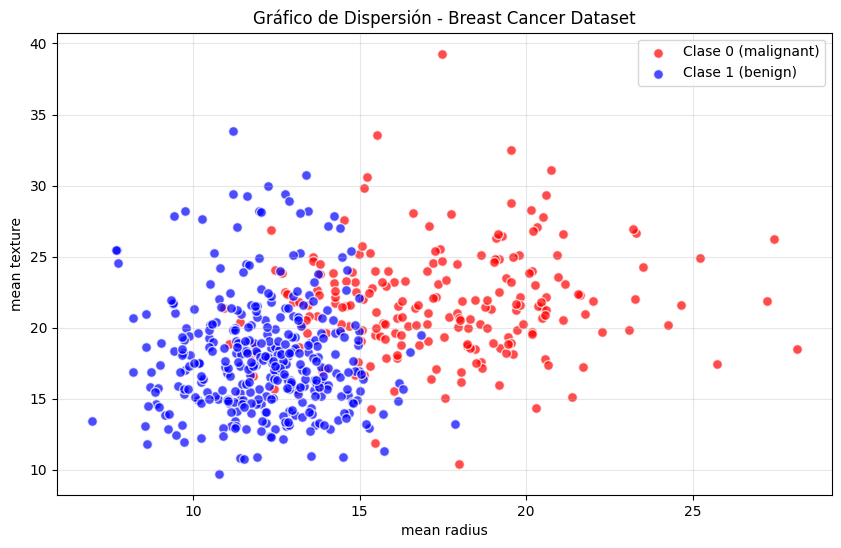


 División de datos:
Entrenamiento: 398 muestras
Prueba: 171 muestras
Características: 30


In [2]:
# Cargar dataset de ejemplo
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target

# Crear DataFrame para análisis
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("Análisis Estadístico del Dataset")
print("=" * 50)
print(f"Dimensiones: {df.shape}")
print(f"\nEstadísticas descriptivas:")
print(df.describe().round(2))

print(f"\nDistribución de clases:")
print(df['target'].value_counts())
print(f"Proporción: {df['target'].value_counts(normalize=True).round(3)}")

# Seleccionar 2 características para visualización
feature1, feature2 = 'mean radius', 'mean texture'
X_vis = df[[feature1, feature2]].values

# Gráfico de Dispersión
plt.figure(figsize=(10, 6))
colors = ['red', 'blue']
for i, class_name in enumerate([0, 1]):
    plt.scatter(X_vis[y == class_name, 0],
                X_vis[y == class_name, 1],
                c=colors[i],
                label=f'Clase {class_name} ({data.target_names[class_name]})',
                alpha=0.7,
                edgecolors='w',
                s=50)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Gráfico de Dispersión - Breast Cancer Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n División de datos:")
print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Prueba: {X_test.shape[0]} muestras")
print(f"Características: {X_train.shape[1]}")

# Entrenamiento del Modelo

In [3]:
# Crear pipeline con escalado y modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        penalty='l2',
        solver='liblinear'
    ))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

print(" Modelo entrenado exitosamente")
print(f"Coeficientes: {pipeline.named_steps['logreg'].coef_[0][:5]}...")  # Primeros 5
print(f"Intercepto: {pipeline.named_steps['logreg'].intercept_}")

 Modelo entrenado exitosamente
Coeficientes: [-0.48431991 -0.46467509 -0.4503601  -0.55685253 -0.15972054]...
Intercepto: [0.17757634]


# Prediction

In [4]:
def predecir_clase(caracteristicas, pipeline, feature_names, target_names):
    """
    Función para predecir la clase de un nuevo patrón

    Args:
        caracteristicas: Lista o array con las características
        pipeline: Pipeline entrenado
        feature_names: Nombres de las características
        target_names: Nombres de las clases

    Returns:
        Clase predicha y probabilidades
    """
    # Convertir a array
    if len(caracteristicas) != len(feature_names):
        print(f" Error: Se esperaban {len(feature_names)} características")
        return None, None

    caracteristicas_array = np.array(caracteristicas).reshape(1, -1)

    # Predecir clase y probabilidades
    clase_predicha = pipeline.predict(caracteristicas_array)[0]
    probabilidades = pipeline.predict_proba(caracteristicas_array)[0]

    print(f" RESULTADOS DE LA PREDICCIÓN:")
    print(f"=" * 40)
    print(f"Características de entrada:")
    for i, (caract, nombre) in enumerate(zip(caracteristicas, feature_names)):
        print(f"  {nombre}: {caract}")

    print(f"\nProbabilidades:")
    for i, prob in enumerate(probabilidades):
        print(f"  {target_names[i]}: {prob:.4f} ({prob*100:.2f}%)")

    print(f"\n Clase predicha: {clase_predicha} ({target_names[clase_predicha]})")
    print(f"Umbral de decisión: 0.5")

    return clase_predicha, probabilidades

# Ejemplo de predicción con valores reales del dataset
print("EJEMPLO DE PREDICCIÓN:")
print("=" * 50)
# Tomar una muestra real del conjunto de prueba
muestra_idx = 0
caracteristicas_ejemplo = X_test[muestra_idx]
clase_real = y_test[muestra_idx]

clase_pred, probs = predecir_clase(
    caracteristicas_ejemplo,
    pipeline,
    data.feature_names,
    data.target_names
)
print(f"\n Clase real: {clase_real} ({data.target_names[clase_real]})")
print(f" Predicción correcta: {clase_pred == clase_real}")

EJEMPLO DE PREDICCIÓN:
 RESULTADOS DE LA PREDICCIÓN:
Características de entrada:
  mean radius: 13.73
  mean texture: 22.61
  mean perimeter: 93.6
  mean area: 578.3
  mean smoothness: 0.1131
  mean compactness: 0.2293
  mean concavity: 0.2128
  mean concave points: 0.08025
  mean symmetry: 0.2069
  mean fractal dimension: 0.07682
  radius error: 0.2121
  texture error: 1.169
  perimeter error: 2.061
  area error: 19.21
  smoothness error: 0.006429
  compactness error: 0.05936
  concavity error: 0.05501
  concave points error: 0.01628
  symmetry error: 0.01961
  fractal dimension error: 0.008093
  worst radius: 15.03
  worst texture: 32.01
  worst perimeter: 108.8
  worst area: 697.7
  worst smoothness: 0.1651
  worst compactness: 0.7725
  worst concavity: 0.6943
  worst concave points: 0.2208
  worst symmetry: 0.3596
  worst fractal dimension: 0.1431

Probabilidades:
  malignant: 0.9684 (96.84%)
  benign: 0.0316 (3.16%)

 Clase predicha: 0 (malignant)
Umbral de decisión: 0.5

 Clase r

# Model Evaluation

 EVALUACIÓN DEL MODELO

 MATRIZ DE CONFUSIÓN:


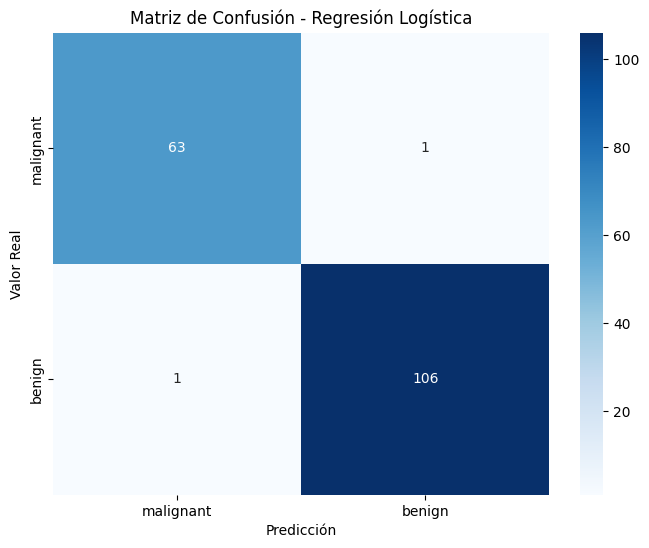


 EXPLICACIÓN DE LA MATRIZ DE CONFUSIÓN:
Verdaderos Negativos (TN): 63 - Correctamente clasificados como malignant
Falsos Positivos (FP): 1 - malignant incorrectamente clasificados como benign
Falsos Negativos (FN): 1 - benign incorrectamente clasificados como malignant
Verdaderos Positivos (TP): 106 - Correctamente clasificados como benign

 ACCURACY (EXACTITUD): 0.9883

 INTERPRETACIÓN DEL ACCURACY:
El modelo clasifica correctamente el 98.83% de las instancias
Esto significa que:
   Correctas: 169 de 171 muestras
   Incorrectas: 2 de 171 muestras

 MÉTRICAS ADICIONALES:
Precision: 0.9907 - Capacidad de no clasificar negativos como positivos
Recall: 0.9907 - Capacidad de encontrar todos los positivos
F1-Score: 0.9907 - Media armónica entre precision y recall

 REPORTE DE CLASIFICACIÓN DETALLADO:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        64
      benign       0.99      0.99      0.99       107

    accuracy                

In [5]:
# Predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

print(" EVALUACIÓN DEL MODELO")
print("=" * 50)

# Matriz de Confusión
print("\n MATRIZ DE CONFUSIÓN:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# Explicación de la matriz de confusión
print("\n EXPLICACIÓN DE LA MATRIZ DE CONFUSIÓN:")
tn, fp, fn, tp = cm.ravel()
print(f"Verdaderos Negativos (TN): {tn} - Correctamente clasificados como {data.target_names[0]}")
print(f"Falsos Positivos (FP): {fp} - {data.target_names[0]} incorrectamente clasificados como {data.target_names[1]}")
print(f"Falsos Negativos (FN): {fn} - {data.target_names[1]} incorrectamente clasificados como {data.target_names[0]}")
print(f"Verdaderos Positivos (TP): {tp} - Correctamente clasificados como {data.target_names[1]}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n ACCURACY (EXACTITUD): {accuracy:.4f}")

# Interpretación del accuracy
total_muestras = len(y_test)
correctas = tn + tp
incorrectas = fp + fn

print(f"\n INTERPRETACIÓN DEL ACCURACY:")
print(f"El modelo clasifica correctamente el {accuracy*100:.2f}% de las instancias")
print(f"Esto significa que:")
print(f"   Correctas: {correctas} de {total_muestras} muestras")
print(f"   Incorrectas: {incorrectas} de {total_muestras} muestras")

# Métricas adicionales
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n MÉTRICAS ADICIONALES:")
print(f"Precision: {precision:.4f} - Capacidad de no clasificar negativos como positivos")
print(f"Recall: {recall:.4f} - Capacidad de encontrar todos los positivos")
print(f"F1-Score: {f1:.4f} - Media armónica entre precision y recall")

print("\n REPORTE DE CLASIFICACIÓN DETALLADO:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# Visualización de Probabilidades


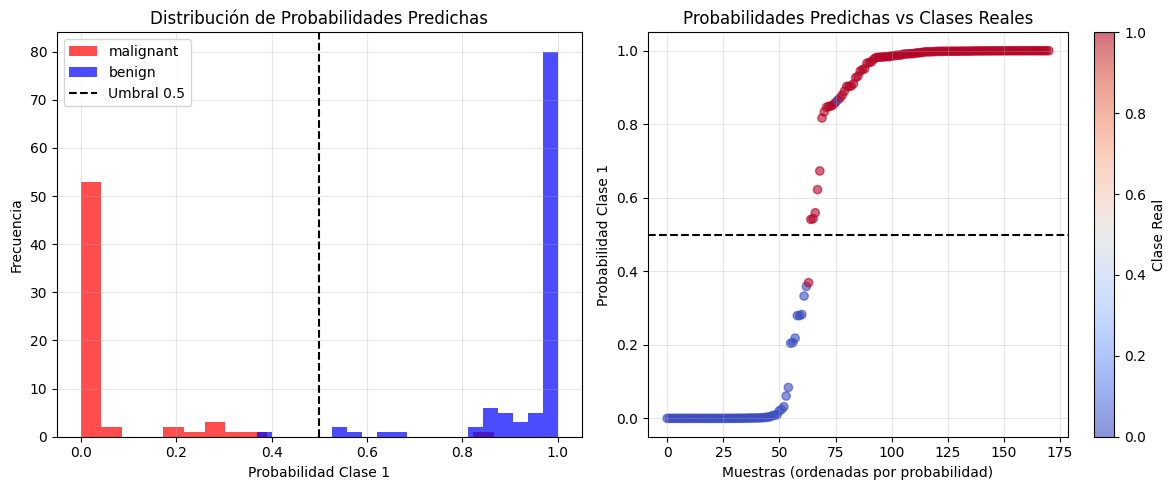

In [6]:
# Visualización de probabilidades predichas
plt.figure(figsize=(12, 5))

# Histograma de probabilidades para cada clase
plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0][:, 1], bins=20, alpha=0.7,
         label=data.target_names[0], color='red')
plt.hist(y_pred_proba[y_test == 1][:, 1], bins=20, alpha=0.7,
         label=data.target_names[1], color='blue')
plt.axvline(x=0.5, color='black', linestyle='--', label='Umbral 0.5')
plt.xlabel('Probabilidad Clase 1')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades Predichas')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico de probabilidades ordenadas
plt.subplot(1, 2, 2)
indices_ordenados = np.argsort(y_pred_proba[:, 1])
probabilidades_ordenadas = y_pred_proba[indices_ordenados, 1]
clases_reales_ordenadas = y_test[indices_ordenados]

plt.scatter(range(len(probabilidades_ordenadas)), probabilidades_ordenadas,
            c=clases_reales_ordenadas, cmap='coolwarm', alpha=0.6)
plt.axhline(y=0.5, color='black', linestyle='--', label='Umbral 0.5')
plt.xlabel('Muestras (ordenadas por probabilidad)')
plt.ylabel('Probabilidad Clase 1')
plt.title('Probabilidades Predichas vs Clases Reales')
plt.colorbar(label='Clase Real')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Bibliografía**

* Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning. Springer.
* Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. JMLR.
* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning. Springer.
* Documentación scikit-learn: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression